# Task 1: 

## Computing Value at Risk using Monte Carlo simulations. 

In [2]:
import numpy as np
import pandas as pd
import pickle  
import matplotlib.pyplot as plt

### Pseudo-Code for using Monte Carlo to calculate VaR and Expected Shortfall (ES)

* $n=3$ is the number of assets.
* $m=5000$ is the number of samples/simulations I carried out.
* $T=10$ is the $10$ days time horizon.
* $M=252$ be the number of days I look back in for each asset to compute mean and std. 
* Let $S_i(0)$ be the today's price of the $i^{th}$ asset in the portfolio where $i\in\{1,\dots,n\}$.
* Let $c_i = 100$ be the number of contracts of $i^{th}$ asset we have in our portfolio. In our example, they are all identical but in reality, they can be different depending on your position. 
* Let $P_p(0) = \sum_{i=1}^{n} c_iS_i(0)$ be the initial portfolio price.
* Let $w = \{w_i\}_{i\in\{1,\dots,n\}}\in\mathbb{R}^n$ be the weight of EACH asset of the portfolio where $w_i = \frac{c_iS_i(0)}{P_p(0)}$ for $i\in\{1,\dots,n\}$.
* Let $H\in\mathbb{R}^{n\times M}$ be a matrix storing the HISTORICAL data of $M$ days and $n$ assets. 
* Let $$R = \frac{H[:,1:]}{H[:,:-1]} - 1 \in \mathbb{R}^{n\times (M-1)}$$ be a $n$ by $M-1$ RETURNS matrix storing all the returns for $n$ assets where $R_{ij} = \frac{H_{i,j+1}}{H_{ij}}- 1$ and $i\in\{1,\dots,n\}$, $j\in\{1,\dots,M-1\}$.
* Let $\mu\in\mathbb{R}^n$ be the return mean vector for each asset where $$\mu_i = \frac{\sum_{j=1}^{M-1} R_{ij}}{M-1}$$. Note, here I have computed $\textbf{Equally weighted mean}$ but I think it is better to give a higher weightage to more recent return values. Hence, we using $\textbf{Exponentially weighted mean}$ is a good idea which I omitted for simplicity. 
* Let $\Sigma \in \mathbb{R^{n\times n}}$ be the correlation matrix of the returns of assets in the portfolio.
* Let $D = \sqrt{diag(\Sigma)}\in \mathbb{R^{n\times n}}$ be the the diagonal matrix storing standard deviation of each asset where $D_{ii} = \sqrt{\Sigma_{ii}} = \sigma_{i}$.
* Let: 
$$\Sigma = LL^T$$ be a __Cholesky Decomposition__ of correlation matrix and $L$ is a __lower triangular matrix__. 

* $\textbf{For $k = 1:m$}$:  $\quad \quad(\textit{OUTER loop}$)
    - Take $prod^{(k,0)} = \mathbb{1}\in\mathbb{R}^n$ is a $n$ dimensional vector of just ones. I need it in the future. 
    
    - $\textbf{For $j = 1:T$}$: $\quad \quad(\textit{INNER loop}$)
        * Let $X^{(k,j)}\in\mathbb{R}^{n}$ be __independent standard normal vector__ i.e. each $X^{(k,j)}_i\sim N(0,1)$ and $Cov(X^{(k,j)}_i,X^{(k,j)}_p) = 0$ where $i\neq p$. 
        * Let $Y^{(k,j)} = LX^{(k,j)}$ be __CORRELATED standard normal vector__ i.e. each $Y^{(k,j)}_i\sim N(0,1)$ and $Cov(Y^{(k,j)}_i,Y^{(k,j)}_p)\neq 0$ necessarily. 
        * $r^{(k,j)} = \mu + DY^{(k,j)} $ is a $n$ dimensional return vector for storing the return of EACH asset. I have $\textbf{assumed that returns of EACH asset are normally distributed with mean}$ $\mu_i$ and variance $\sigma_i^2$ i.e $r^{(k,j)}_i\sim N(\mu_i, \sigma_i^2)$ and $r^{(k,j)}_i = \mu_i + \sigma_iY^{(k,j)}_i$ for $i\in\{1,\dots,n\}$.  
        * $prod^{(k,j+1)} = prod^{(k,j)}*(\mathbb{1}+r^{(k,j)})$ is a bit like you are stepping through the time $1$ to $T$ and computing the returns of EACH asset by random simulations which is then compounded. 
    - Now we step out of the INNER loop and compute the __portfolio return at the $k^{th}$ outer iteration__: 
    $$P^{(k)}_r = \sum_{i=1}^{n} w_i*prod^{(k,T)}_i \in\mathbb{R}$$.
* Now we step out of the OUTER loop, and take: 
$$\textbf{P}_r = \{P_r^{(1)},\dots,P_r^{(m)}\}\in\mathbb{R}^m$$ be a __$m$ dimensional vector of all the portfolio returns simulated above__. 
* $\text{Loss_vec} = P_p(0)[\textbf{P}_r - \mathbb{1}] \in \mathbb{R}^m$ stores how the __price of the portfolio__ i.e. $P_p(T)$ have changed for today's price to the time horizon $T=10$. 
* SORT the $\text{Loss_vec}$ vector in the ascending order such that:
$$\tilde{P}_r^{(1)} \leq \dots \leq \tilde{P}_r^{(m)}$$
* Take $\alpha = 0.01$ where $(1-\alpha)$ be the confidence interval to which we are computing our VaR to. 
* Take $idx = \lceil m\alpha \rceil$ which is the index at which we have our VaR value. I just use the $\textbf{ceiling}$ fucntion but you can also $\textbf{interpolate}$ between the indices to get a better estimation of the VaR. 
* $VaR = -\tilde{P}_r^{(idx)}$ is the computation of the value at risk at $(1-\alpha)$ confidence interval. 
* $ES = \frac{-1}{idx}\sum_{k=1}^{idx} \tilde{P}_r^{(k)}$ is the expected shortfall which is basically the average of all the returns below and including the VaR. 

## Monte Carlo Algorithm implemented in Python

In [3]:
'''Here I am setting up the problem by importing all the historic data, 
    computing the mean/std of asset returns and also computing the 
    cholesky decomposition of the correlation matrix etc.'''

no_of_assets = 3; #number of assets
no_of_sims = 5000; #number of simulations.
time_horizon = 10; #time horizon which we are trying to forecast the VaR
go_back_days = 252 # number of days to look at the data in the past to compute the mean/std of asset's returns
alpha = 0.01  # (1-alpha) is the confidence interval we are computing VaR to

tickers = ['FTSE','GSPC','DJI']  #tickers of the assets in the portfolio
no_of_contracts = [100,100,100]  #number of contracts for EACH asset in the portfolio

hist_data_mat = np.zeros((no_of_assets,go_back_days)) #creating an empty numpy matrix
for idx,ticker in enumerate(tickers):
    # creating a matrix which stores all the prices for Each asset
    # I have decided to look back 1 year, in order to compute my mean and variance for EACH asset.
    data = pd.read_csv(f'stock_dfs/{ticker}.csv',
                     parse_dates=True,index_col=0)['Adj Close'].iloc[-go_back_days:]
    hist_data_mat[idx] = data.values
    
# now we will compute the initial price of the portfolio and also the 
# weights of each asset in the portfolio

initial_asset_prices = hist_data_mat[:,-1] #today prices are the last column
initial_portfolio_price = no_of_contracts@initial_asset_prices #initial portfolio price
weights = no_of_contracts*initial_asset_prices/initial_portfolio_price

#Now we compute the return matrix for the historic data
return_data_mat = hist_data_mat[:,1:]/hist_data_mat[:,:-1] - 1

#I am only computing equally weighted mean for simplicity, but I think
# we should be computing some exponentially weighted mean (EWMA).
mean_vec = np.mean(return_data_mat,axis=1)  
std_vec = np.std(return_data_mat,axis=1)  #computing the standard deviation

correlation_mat = np.corrcoef(return_data_mat) #computing the correlation matrix

#cholesky of the correlation matrix
cholesky_mat = np.linalg.cholesky(correlation_mat) 

#### The function in the next cell is going over the Pseudo-Code from above

In [4]:
def mc_VaR_standard_way(printing=False):
    '''This is a the code for my pseudo-code above'''
    portfolio_returns_sims = np.zeros(no_of_sims) #creating an empty zero array

    for k in range(no_of_sims):
        prod_k = np.ones(no_of_assets) #vector of ones of no_of_assets dims
        np.random.seed(k) #fixed a seed 
        for j in range(time_horizon):
            X_kj = np.random.normal(loc = 0.0, scale = 1.0, size=no_of_assets) #generating standard normal sims
            Y_kj = cholesky_mat@X_kj  #correlating them with each other

            # making an assumption that returns of each asset is normally distributed 
            # with mean mu_i and standard deviation simga_i, hence I unstandarise it.
            r_kj = mean_vec + std_vec*Y_kj   
            prod_k = prod_k*(1+r_kj)  #a bit like I am stepping through the time horizon and doing compound interest
        portfolio_returns_sims[k] = weights@prod_k  #simulated returns of the portfolio in the kth sim

    loss_vector = initial_portfolio_price*(portfolio_returns_sims - 1) #change in the portfolio price at t= 0  and t=T
    sorted_loss_vector = np.sort(loss_vector) #sorting the loss vector
    #finding the index where we have VaR value
    #I just took the ceiling function here but feel free to interpolate here
    index = int(np.ceil(alpha*no_of_sims)) - 1 
    full_VaR = sorted_loss_vector[index]  #computing the VaR 
    ES = sum(sorted_loss_vector[:index+1])/(index+1) #computing the Expected Shortfall (ES)

    if printing:
        print(f'\n- Weights of EACH asset in the portfolio: {weights}')
        print(f'- Initial Price of portfolio: $ {initial_portfolio_price}')
        print(f'- Returns mean for EACH asset: {mean_vec}')
        print(f'- Returns standard deviation for EACH asset: {std_vec}\n')
        print(f'- Correlation Matrix:\n{correlation_mat}\n')
        print(f'- Cholesky of correlation Matrix:\n{cholesky_mat}\n')
        print(f'- {time_horizon} days VaR with {(1-alpha)*100}% CI: $ {-full_VaR}')
        print(f'- {time_horizon} days Expected Shortfall (ES) with {(1-alpha)*100}% CI: $ {-ES}')
    
    return full_VaR

full_Var = mc_VaR_standard_way(printing=True)
print('='*100)


- Weights of EACH asset in the portfolio: [0.17845374 0.08784974 0.73369653]
- Initial Price of portfolio: $ 3526180.1026
- Returns mean for EACH asset: [-0.00050482  0.00041671  0.00012605]
- Returns standard deviation for EACH asset: [0.01718761 0.02099971 0.02244853]

- Correlation Matrix:
[[1.         0.43567089 0.44079814]
 [0.43567089 1.         0.98960116]
 [0.44079814 0.98960116 1.        ]]

- Cholesky of correlation Matrix:
[[1.         0.         0.        ]
 [0.43567089 0.90010604 0.        ]
 [0.44079814 0.88607143 0.14343787]]

- 10 days VaR with 99.0% CI: $ 489116.5021047638
- 10 days Expected Shortfall (ES) with 99.0% CI: $ 536358.6035242678


### Simpler Case Monte Carlo: Computing one day VaR and then extending it to T days by multiplying by $\sqrt{T}$

#### This is also the MC method, but I have assumed that returns of EACH assets are I.I.D with respect to EACH day. Hence, scaling by a factor of $\sqrt{T}$ (as Brownian Motion is of the order $O(\sqrt{T}))$. 

In [5]:
def mc_VaR_simpler(printing=False):
    portfolio_returns_sims = np.zeros(no_of_sims) #creating an empty zero array

    for k in range(no_of_sims):
        np.random.seed(k) #fixed a seed 
        X_k = np.random.normal(loc = 0.0, scale = 1.0, size=no_of_assets) #generating standard normal sims
        Y_k = cholesky_mat@X_k  #correlating them with each other and Y_k is also standard normal.

        #making an assumption that returns of each asset is normally distributed 
        # with mean mu_i and standard deviation sigma_i, hence I unstandarise it
        r_k = mean_vec + std_vec*Y_k   
        portfolio_returns_sims[k] = weights@(1+r_k)  #simulated returns of portfolio in the kth sim

    loss_vector = initial_portfolio_price*(portfolio_returns_sims-1)
    sorted_loss_vector = np.sort(loss_vector)
    index = int(np.ceil(alpha*no_of_sims)) - 1 #I just took the ceiling function here but feel free to interpolate here
    one_day_VaR = sorted_loss_vector[index] #computing the one-day-VaR here
    full_VaR = one_day_VaR*np.sqrt(time_horizon) #extending to a T day VaR

    ES = np.sqrt(time_horizon)*sum(sorted_loss_vector[:index+1])/(index+1) #expected shortfall
    
    if printing:
        print(f'\n- Weights of EACH asset in the portfolio: {weights}')
        print(f'- Initial Price of portfolio: $ {initial_portfolio_price}')
        print(f'- Returns mean for EACH asset: {mean_vec}')
        print(f'- Returns standard deviation for EACH asset: {std_vec}\n')
        print(f'- Correlation Matrix:\n{correlation_mat}\n')
        print(f'- Cholesky of correlation Matrix:\n{cholesky_mat}\n')
        print(f'- {time_horizon} days VaR with {(1-alpha)*100}% CI: $ {-full_VaR}')
        print(f'- {time_horizon} days Expected Shortfall (ES) with {(1-alpha)*100}% CI: $ {-ES}')
        
    return full_VaR, one_day_VaR
        
full_Var = mc_VaR_simpler(printing=True)
print('='*100)


- Weights of EACH asset in the portfolio: [0.17845374 0.08784974 0.73369653]
- Initial Price of portfolio: $ 3526180.1026
- Returns mean for EACH asset: [-0.00050482  0.00041671  0.00012605]
- Returns standard deviation for EACH asset: [0.01718761 0.02099971 0.02244853]

- Correlation Matrix:
[[1.         0.43567089 0.44079814]
 [0.43567089 1.         0.98960116]
 [0.44079814 0.98960116 1.        ]]

- Cholesky of correlation Matrix:
[[1.         0.         0.        ]
 [0.43567089 0.90010604 0.        ]
 [0.44079814 0.88607143 0.14343787]]

- 10 days VaR with 99.0% CI: $ 520478.83083847695
- 10 days Expected Shortfall (ES) with 99.0% CI: $ 583371.2583380311


## Experiments

#### 1. Now that we have used two different MC ways of computing VaR, we compare whether VaR converges to a solution (or like some sufficiently small neighbourhood) as we vary the number of simulation (number of samples) and keep Time_Horizon and random seed fixed. 

In [9]:
max_iters = 30000  #maximum number of simulations

different_no_of_sims = np.arange(100,max_iters,500)  #going up in the increments of 500

mc_standard_way = np.zeros(len(different_no_of_sims))  #this is where we will store data for first MC method
mc_simpler_way = np.zeros(len(different_no_of_sims))   ##this is where we will store data for second MC method

for idx,no_of_sims in enumerate(different_no_of_sims):
    mc_standard_way[idx] = mc_VaR_standard_way()
    mc_simpler_way[idx] = mc_VaR_simpler()[0]

In [12]:
'''We will store our data in pickle format which will speed up plotting process'''

pickle_out_mc_standard = open(f'stock_dfs/standard_way_{max_iters}.pickle','wb')
pickle.dump(mc_standard_way,pickle_out_mc_standard)
pickle_out_mc_standard.close()

pickle_out_mc_simple = open(f'stock_dfs/simple_way_{max_iters}.pickle','wb')
pickle.dump(mc_simpler_way,pickle_out_mc_simple)
pickle_out_mc_standard.close()

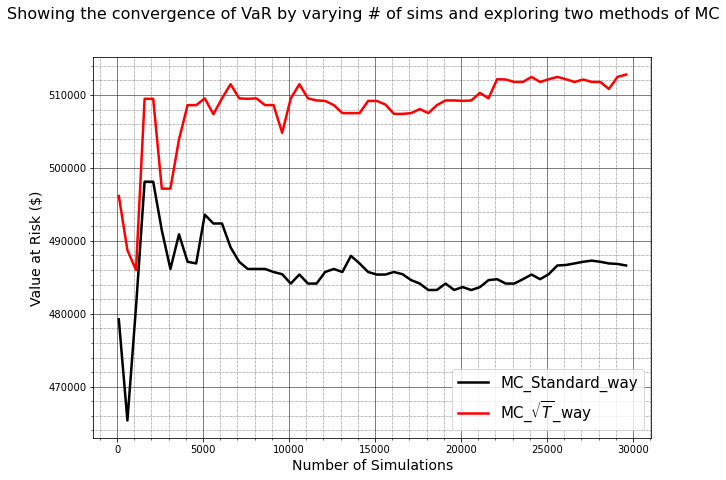

In [13]:
# max_iters = 5000
# different_no_of_sims = np.arange(100,max_iters,500)
mc_standard_way1 = pickle.load(open(f'stock_dfs/standard_way_{max_iters}.pickle','rb'))
mc_simpler_way1 =  pickle.load(open(f'stock_dfs/simple_way_{max_iters}.pickle','rb'))

#Plotting the convergence of VaR for Standard MC way when I vary the no. of samples
plt.figure(figsize=(10,7))
plt.plot(different_no_of_sims,-mc_standard_way1,color = 'k',lw=2.5,label = 'MC_Standard_way');
plt.plot(different_no_of_sims,-mc_simpler_way1,color = 'r',lw=2.5, label = r'MC_$\sqrt{T}$_way');
plt.legend(prop={'size': 15})
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='k')
plt.xlabel('Number of Simulations',fontsize = 14)
plt.ylabel('Value at Risk ($)', fontsize  =14)
plt.suptitle('Showing the convergence of VaR by varying # of sims and exploring two methods of MC',fontsize = 16);

__Observations__

We see that the VaR stabilises in both MC methods after around 6000 simulations. The simpler case (i.e. when we compute one-day VaR and then extend it to time horizon $T$ by multipying by $\sqrt{T}$), is consistently above the the standard way. This could be because, in simpler case, we assume that the portfolio returns are __I.I.D__ which may not match emperical behaviour. Typically, scaling VaR to a higher horizon leads to a more conservative VaR. This case extends one-day VaR to a larger time horizon by an increasing function (i.e. $VaR(T) = Var(1)\sqrt{T}$) which is __unbounded__ from above. Whereas, the standard way, does not assume this I.I.D assumption and carries on compound interest over the time horizon. Which maybe more realistic. However, the standard way is much more expensive as we have to loop over the time horizon. For many practical situation, using the simpler way is satisfactory. 

### 2. Now we will see how Time-Horizon $T$ affect the value of VaR using the two separate MC methods. 

#### We fix number of sims  to 8000 and vary time-horizon from 1 to 30 days. 

In [122]:
no_of_sims = 8000; #number of simulations
time_horizons = np.arange(1,30,1); #time horizon which we are trying to forecast the VaR

one_day_VaR = -mc_VaR_simpler()[1]  #computing 1 day VaR
mc_simpler_way_results = [one_day_VaR*np.sqrt(time_horizon) for time_horizon in time_horizons]  #computing the T-day VaR using simple case 
mc_standard_way_results = np.zeros(len(time_horizons))

for j,time_horizon in enumerate(time_horizons):
    mc_standard_way_results[j] = -mc_VaR_standard_way()

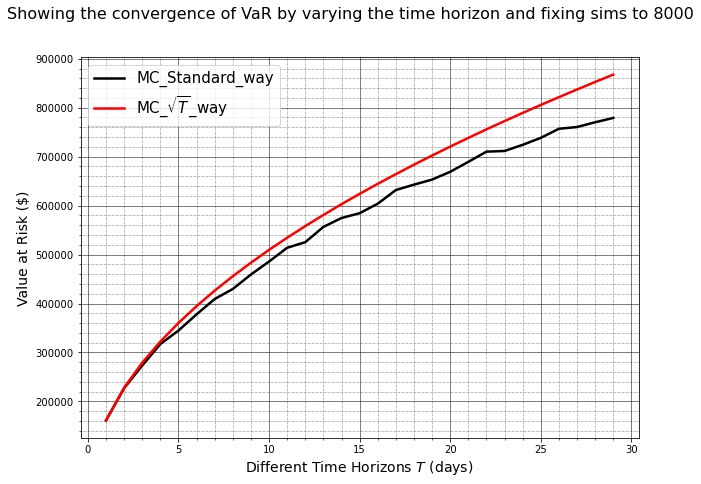

In [129]:
plt.figure(figsize=(10,7))

plt.plot(time_horizons,mc_standard_way_results,color = 'k',lw=2.5,label = 'MC_Standard_way');
plt.plot(time_horizons,mc_simpler_way_results, color = 'r',lw=2.5, label = r'MC_$\sqrt{T}$_way');
plt.legend(prop={'size': 15})
plt.xlabel(r'Different Time Horizons $T$ (days)',fontsize = 14)
plt.ylabel('Value at Risk ($)', fontsize  =14)
plt.suptitle('Showing the convergence of VaR by varying the time horizon and fixing sims to 8000',fontsize = 16);
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='k')

#### Observations

By the results we have got, it seems like the simpler way seems to __overestimate__ VaR due to the independent assumptions between EACH day's returns which is unbounded. Whereas, using the standard way, we see a much more realistic increment in the VaR as our time horizon increases. It makes sense since we have an increasing monotonic function and uncertainty increases as we go further into the future about where the prices of assets in our portfolio can head. 

There are other ways to also compute VaR, for example: 

* __Historical Way__: This is where you do not assume any normality distribution on the returns and make use of just the historical data to compute the VaR to a given CI. It is very commonly used and assumes that the past predicts the future well. 
* __Parametric Way__: This is where you use the historical data, to compute the mean and variance of the portfolio returns and make a normality assumption on it. 

I have computed the VaR (and ES) using all the above 3 methods in the __EXCEL SHEET__ so please have a look there too. 

All these methods have different pros and cons and they all used to compute VaR in different situations. They also have small variations to EACH method which can improve the reliability of the VaR in some situations (for example using a weights to compute mean and standard deviation of EACH asset in a portfolio).  